# Active learning technique

## Libraries

In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.svm import SVC, LinearSVC
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


## Iris dataset

In [19]:
file_path = 'Iris.csv'
iris_labelled = pd.read_csv(file_path)

In [20]:
# Supprimer les données de l'espèce 'setosa' et les features des sepales
iris_labelled = iris_labelled[iris_labelled['Species'] != 'Iris-setosa']

In [21]:
iris_labelled.drop(['SepalWidthCm', 'SepalLengthCm','Id'], axis=1,inplace=True)
iris_labelled.reset_index(drop=True, inplace=True)

In [22]:
def plotting(df,feature="Petal"):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature+'LengthCm', y=feature+'WidthCm', hue='Species', style='Species', palette='bright')
    plt.title(feature+' Length vs '+feature+' Width by Species')
    plt.xlabel(feature+' Length')
    plt.ylabel(feature+' Width')
    plt.legend(title='Species')
    plt.show()

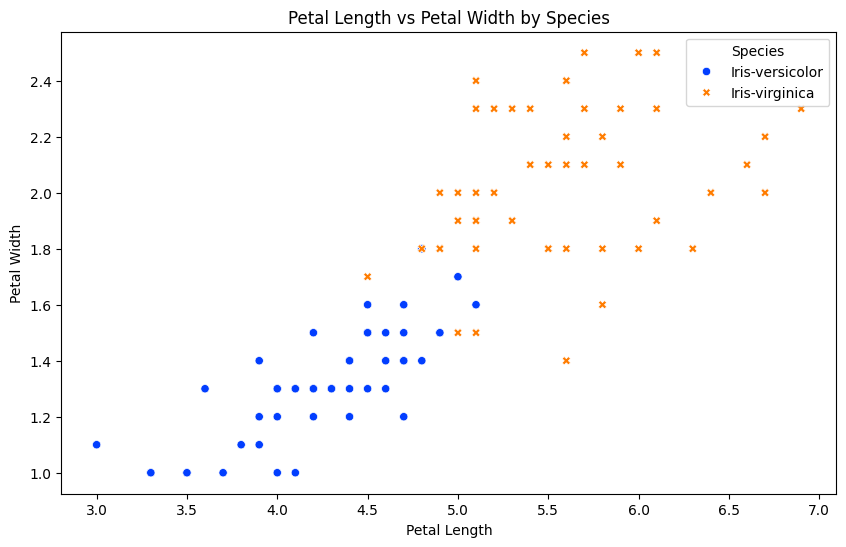

In [23]:
plotting(iris_labelled,"Petal")

In [24]:
def plotting_with_decision_boundary(X,y,model):
    
    # Tracer les données
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k')

    # Créer une grille pour visualiser la frontière de décision
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Tracer la frontière de décision et les marges
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Marquer les vecteurs de support
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title('SVM Decision Boundary with the first two Iris classes')
    plt.show()


### Data preparation


In [25]:
X_df = iris_labelled.drop('Species', axis=1)  # Caractéristiques
y_df = iris_labelled['Species']  # Classes

X = X_df.to_numpy()

encoder = LabelEncoder()
y = encoder.fit_transform(y_df)

## SVM with the entire dataset

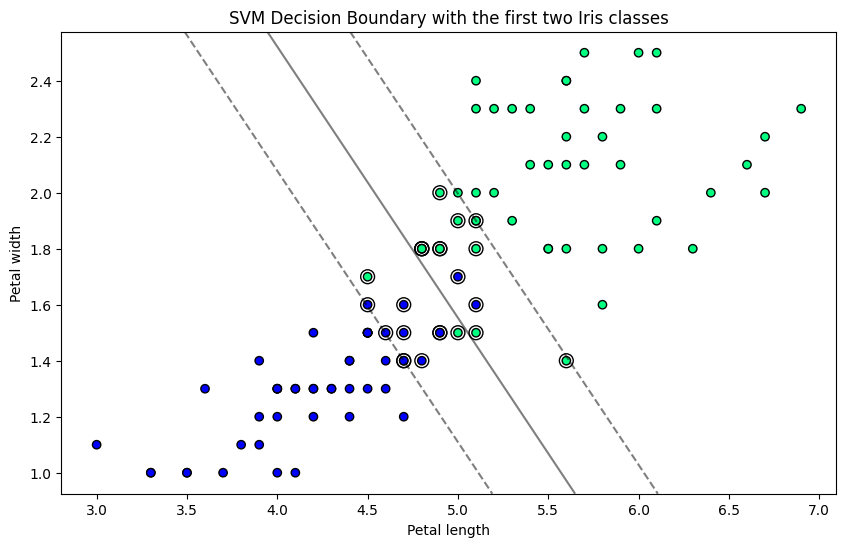

In [26]:
model = SVC(kernel='linear')
model.fit(X, y)
plotting_with_decision_boundary(X,y,model)

## Usefulness of active learning

Now let's imagine having only few labelled samples and **the labelling cost is high**,     
but we still want to classify the entirety of the dataset.  
This is what active learning is for.  
I am going to apply an active learning technique with the SVM algorithm.

In [27]:
def find_most_uncertain(model, X_pool, unlabelled_indexes):
    
    distances = np.abs(model.decision_function(X_pool[unlabelled_indexes]))
    
    # Trouver l'index du point le plus proche de la frontière de décision
    ind = np.argmin(distances)
    
    # Retourner l'index correspondant dans unlabelled_indexes
    return unlabelled_indexes[ind]


In [28]:
def plot_final_and_current_frontier(model_final, model_current, X_pool, y_pool, train_indexes, unknown_indexes,new_point_index=None):
    # Créer une grille pour tracer les frontières de décision
    xx, yy = np.meshgrid(np.linspace(X_pool[:, 0].min(), X_pool[:, 0].max(), 500),
                         np.linspace(X_pool[:, 1].min(), X_pool[:, 1].max(), 500))

    # Prédiction sur la grille pour la frontière courante
    Z_current = model_current.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_current = Z_current.reshape(xx.shape)

    # Prédiction sur la grille pour la frontière finale
    Z_final = model_final.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_final = Z_final.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    
    # Surligner les points inconnus avec une couleur spécifique: noir
    if len(unknown_indexes) > 0:  # Assurer que unknown_indexes contient des éléments
        X_unk = X_pool[unknown_indexes]
        plt.scatter(X_unk[:, 0], X_unk[:, 1], color='black', s=50, label='X_unk')
    
    # Surligner les points dans X_train selon leur classe sans bordure noire
    X_train = X_pool[train_indexes]
    y_train = y_pool[train_indexes]
    for label in np.unique(y_train):
        idx = np.where(y_train == label)
        color = 'red' if label == 0 else 'blue'
        plt.scatter(X_train[idx, 0], X_train[idx, 1], color=color, s=100, alpha=0.9, label=f'X_train (Classe {label})')

    # Tracer la frontière de décision courante et finale
    plt.contour(xx, yy, Z_current, colors='green', levels=[0], alpha=0.5, linestyles=['--'])
    plt.contour(xx, yy, Z_final, colors='blue', levels=[0], alpha=0.5, linestyles=['-'])

    # Créer des légendes personnalisées pour les frontières de décision
    custom_lines = [Line2D([0], [0], color='green', linestyle='--', lw=2),
                    Line2D([0], [0], color='blue', linestyle='-', lw=2),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='X_train (Classe 0)'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='X_train (Classe 1)')]
    
    # Mettre en évidence le nouveau point ajouté à X_train
    if new_point_index is not None:
        plt.scatter(X_pool[new_point_index, 0], X_pool[new_point_index, 1], color='magenta', s=200, label='Nouveau Point', marker='*', edgecolors='w', zorder=5)
    
    # Ajouter la légende au plot
    plt.legend(custom_lines, ['Frontière Courante', 'Frontière Finale', 'X_train (Classe 0)', 'X_train (Classe 1)'])

    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title('Comparaison des frontières de décision avec X_train et X_unknown')
    plt.show()


In [29]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {}
    
    # Calculer les métriques
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred, average='binary')
    metrics['recall'] = recall_score(y_test, y_pred, average='binary')
    metrics['f1'] = f1_score(y_test, y_pred, average='binary')
    
    # Calculer l'AUC si possible
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        metrics['auc'] = roc_auc_score(y_test, y_prob)
    except:
        metrics['auc'] = None
    
    return metrics


In [30]:
def plot_confusion_matrix(model, title, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Tracer la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matrice de confusion de '+title)
    plt.show()

We separate the dataset into a big pool of unlabeled data and a small training set.   
At each iteration, we'll add a label to a point we feel is the most uncertain, and our model will, after just a few iterations, perform better.  

In [31]:
def active_learning_iterations(X,y,n_iterations):
    
    metrics_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

    
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    # Modèle SVM pour la frontière "finale"
    final_classifier = SVC(kernel='linear', C=100)
    final_classifier.fit(X_pool, y_pool)
    
    plot_confusion_matrix(final_classifier, "final", X_test, y_test)
    
    train_indexes = list(range(10))
    unlabelled_indexes = list(range(10, 80))
    
    X_train = X_pool[train_indexes]
    y_train = y_pool[train_indexes]
    
    classifier = LinearSVC(dual=False)
    classifier.fit(X_train, y_train)
    
    # Évaluation du modèle actuel
    metrics = evaluate_model(classifier, X_test, y_test)
    # Stocker les métriques pour cette itération
    for key in metrics_history.keys():
        metrics_history[key].append(metrics[key])
    
    border_points = find_most_uncertain(classifier,X_pool,unlabelled_indexes)
    unlabelled_indexes.remove(border_points)        
    
    plot_final_and_current_frontier(final_classifier,classifier,X_pool,y_pool,train_indexes,unlabelled_indexes)


    for i in range(n_iterations):
                
        train_indexes.append(border_points)
        
        X_train = X_pool[train_indexes]
        y_train = y_pool[train_indexes]

        curr_classifier=SVC(kernel='linear') 
        curr_classifier.fit(X_train, y_train)
        
         # Évaluation du modèle actuel
        metrics = evaluate_model(curr_classifier, X_test, y_test)
        # Stocker les métriques pour cette itération
        for key in metrics_history.keys():
            metrics_history[key].append(metrics[key])
    
        border_points = find_most_uncertain(classifier,X_pool,unlabelled_indexes)
        unlabelled_indexes.remove(border_points)
        
        plot_final_and_current_frontier(final_classifier,curr_classifier,X_pool,y_pool,train_indexes,unlabelled_indexes,border_points)
        
        X=X_train
        y=y_train
        classifier=curr_classifier
        
 
    return metrics_history,classifier

    

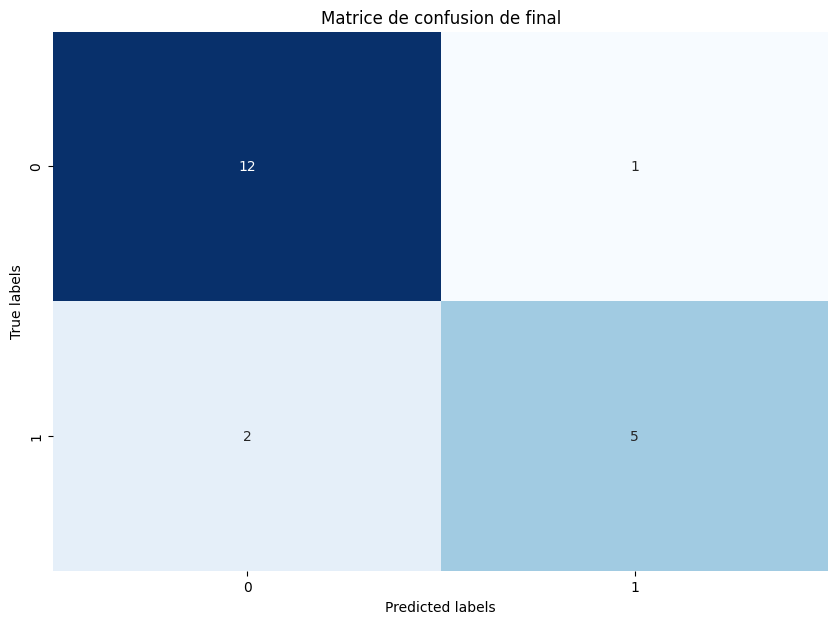

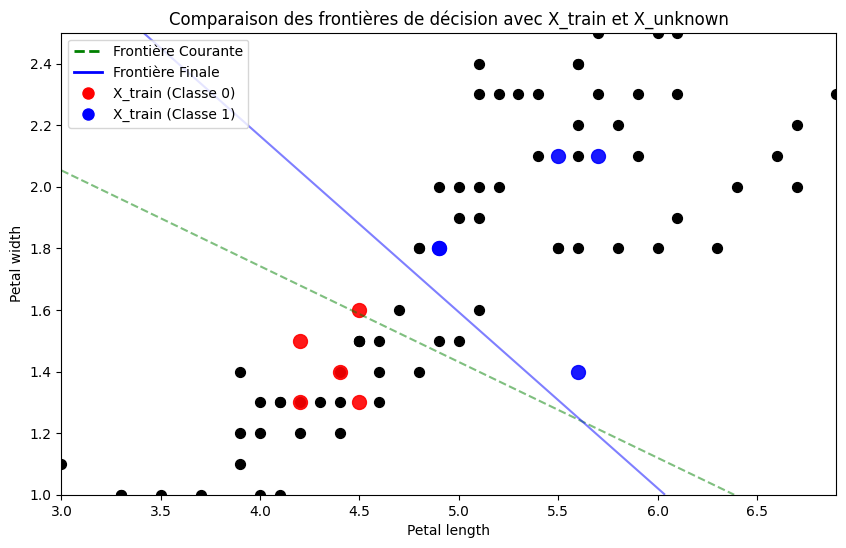

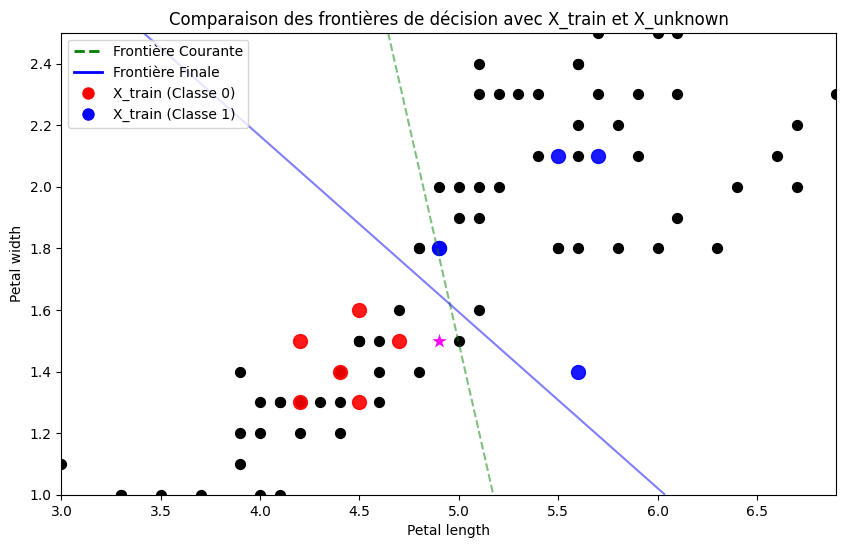

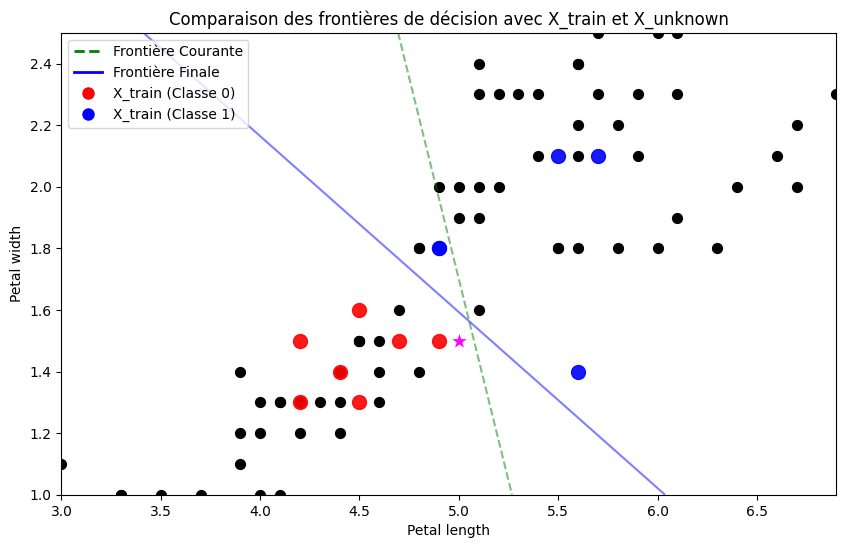

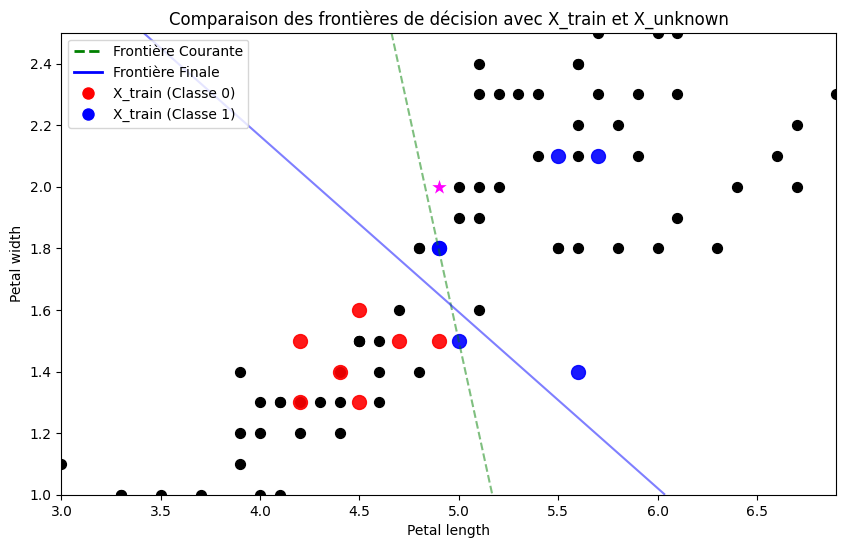

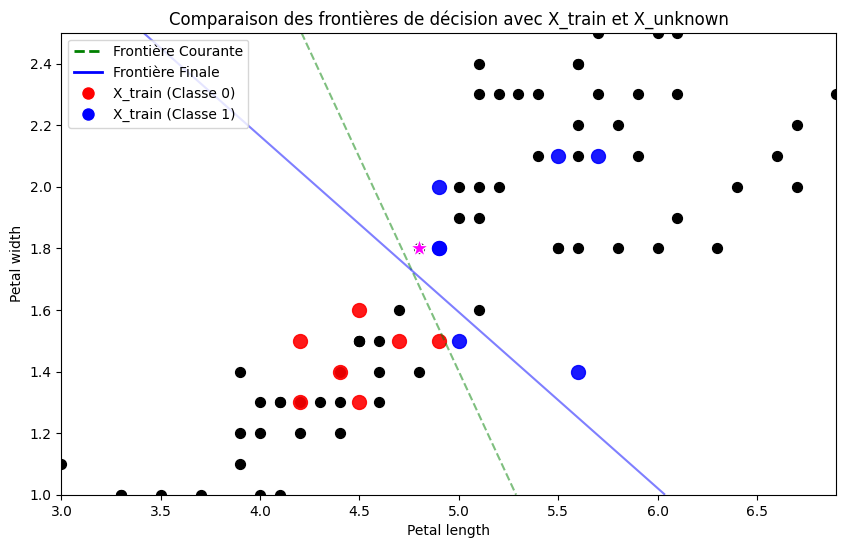

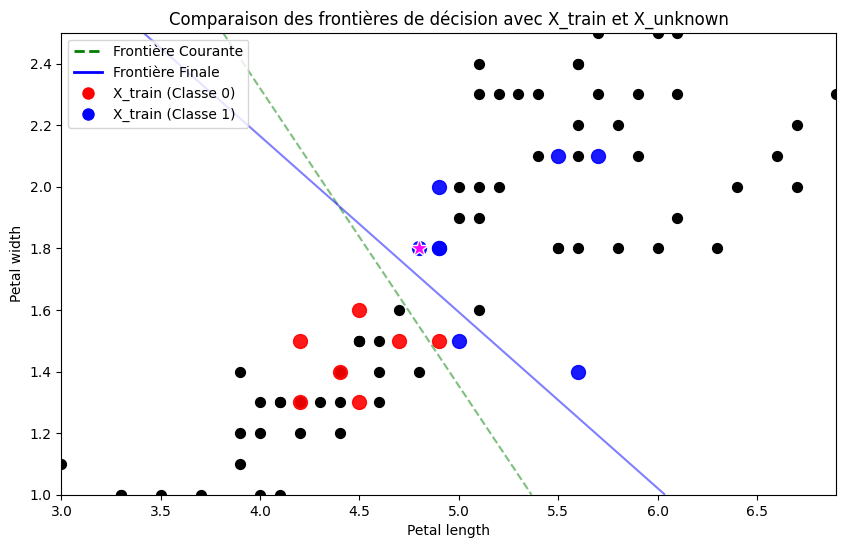

In [32]:
metrics_history,classifier=active_learning_iterations(X,y,5)

In [33]:
def plot_performance(metrics_history):
    
    plt.figure(figsize=(12, 8))

    # Tracer chaque métrique
    for metric, values in metrics_history.items():
        if values[0] is not None:  # Vérifier si la métrique a été calculée
            plt.plot(values, label=metric)

    plt.xlabel('Itérations')
    plt.ylabel('Valeur de la métrique')
    plt.title('Performance du modèle au fil des itérations d\'active learning')
    plt.legend()
    plt.show()


## Results analysis

The recall is better on the active learning model: more relevant items are retrieved than in the SVM version with the full training set.

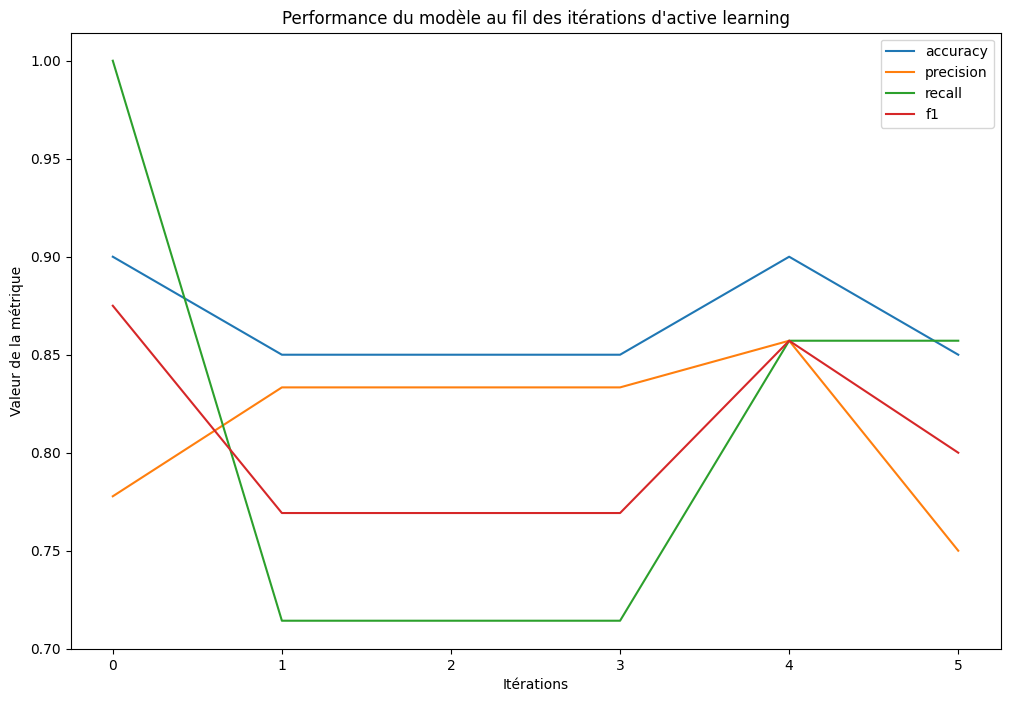

In [34]:
plot_performance(metrics_history)